# Model predicting thermal sensation using given database

Link to database: https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II.git

Packages: 
1. pandas
2. scipy 
3. math - no need 
4. numpy
5. scikit
6. tensorflow and keras

### Creating dataframe 

Using pandas

In [1]:
import pandas as pd 
import pathlib

#create dataframe from data csv file as df
df = pd.read_csv("db_measurements_v2.1.0.csv") 

/tmp/ipykernel_46721/1151135277.py:5: DtypeWarning: Columns (5,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("db_measurements_v2.1.0.csv")


### Handling NaN values

Given the fact that the dataset consists of a collection of different studies, each of which take into consideration varied parameters, the following code calculates the amount of NaN values on each column of the dataframe. The aim here is to find the parameters most commonly used in studies to create a final dataset as consistent as possible.

In [2]:
#cell to find percentage of NaNs per column, types it in txt file

#create percentages
size = df['index'].size + 1
nan_array = df.isnull().sum() / size * 100 #creates a series of the percentages

#store in file
nan_array_string = ["%.2f" % i for i in nan_array] #turns percentages into strings

data = {df.columns[col]: nan_array_string[col] for col in range(nan_array.size)} #makes dict and dataframe
nan_df = pd.DataFrame(data.items())

path = str(pathlib.Path().resolve()) + '\data.csv' #stores in file
nan_df.to_csv(path, header=None, index = None, sep = ' ')

Now, sorting the dataset's columns by their amount of NaN values can allow for an easy selection of columns to keep for the analysis and later prediction.

In [3]:
#sort through nan series and cut all percentages above 50%

nan_array_sorted = nan_array.sort_values(ascending=True) #sorts throught the series 
nan_array_sorted = nan_array_sorted[nan_array_sorted<50.0] #only keeps columns with below 50% NaN cells 

path = str(pathlib.Path().resolve()) + '\data_sorted.csv' #stores file for future use
nan_array_sorted.to_csv(path, header = None, sep = ' ')

According to the file produced and relevant bibliography and keeping in mind that the ultimate goal of this project is to predict thermal comfort using MET and HRV, the parameters to be included in the final dataset are:

1. index - for practical purposes 
2. building_id - to separate studies during outlier detection 
3. ta - temperature 
4. rh - humidity 
5. vel - air velocity 
6. met - due to its relevance for this work 
7. thermal sensation - the final predicted value  

Removing NaN value rows - maybe reconsider?

In [4]:
#keeping only the columns considered relevant
df_main  = df[['index','building_id','ta', 'rh', 'vel', 'met', 'thermal_sensation']]

#removing NaN values
df_main = df_main.dropna()
size_new = df_main['building_id'].size + 1
loss = 100 - size_new / size * 100
print(loss, size, size_new)

#making databases to use for outlier detection
df_outliers = df_main[['building_id', 'ta', 'rh', 'vel', 'met', 'thermal_sensation']]
df_measures = df_main[['ta', 'rh', 'vel', 'met', 'thermal_sensation']]

23.175339802263522 109034 83765


23% dataset loss (????)

### Outlier detection

For the outlier detection different methods are tried below. 

In [ ]:
#plotting outliers for better understanding i think 
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.boxplot(x=df_outliers['rh'])

#judging by the plot, temperature sounds like it shouldn't be getting analyzed that way
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df_outliers['rh'], df_outliers['building_id'])
ax.set_xlabel('humidity')
ax.set_ylabel('research')
plt.show()


Z-scores : Describes the point's position relative to the mean of the group (column) in amount of standard deviations - here an outlier would be a point with a z-score of higher than abs(3). The algorithm is not considered as effective since it requires (assumes) a mean. However, potentially useful to know around how many points to expect as outliers during multidimensional analysis.

In [ ]:
#different outlier methods
#z-scores 
import scipy.stats as stats
import math
from IPython.display import display

df_zscore = stats.zscore(df_measures.copy())
df_zscore['outlier'] = 0


def zfunc(column):
    counter = 0
    for index, cell in df_zscore[column].items(): 
        if (not math.isnan(cell)) and (cell>3 or cell<-3):
            counter+=1
            df_zscore.loc[index, 'outlier']= 1
    print ('Number of outliers in column ' + column + ' is: ' + str(counter))
    return 0

for col in df_measures.columns: 
    zfunc(col)

counter = 0
for cell in df_zscore['outlier']: 
    if cell == 1: counter += 1
print('Number of total outliers is: ' + str(counter))

IQR : Measures the spread of the middle 50% of the data in a column - here an outlier would be a point that would fall out of the 50% range by +/- 1.5 times that range.

In [ ]:
#different outlier methods 
#iqr  
import numpy as np 
import math

df_iqr = df_measures.copy()
df_iqr['outlier'] = 0 

def iqr_func(column):
    q75, q25 = np.percentile(df_iqr[column], [75, 25])
    iqr = q75 - q25
    valid = iqr*2.5 
    counter = 0
    for index, cell in df_iqr[column].items():
        if  (not math.isnan(cell)) and (cell>q75+valid or cell<q25-valid): 
            df_iqr.loc[index, 'outlier'] = 1
            counter+=1
    print ('Number of outliers in column ' + column + " is: " + str(counter))
    return 0

for col in df_measures.columns: 
    iqr_func(col)

counter = 0
for cell in df_iqr['outlier']: 
    if cell ==1: counter += 1
print('Number of total outliers is: ' + str(counter))

Isolation forest : Detects anomalies based on distance taking multiple parameters into consideration.

In [ ]:
#different outlier methods 
#Isolation tree
from sklearn.ensemble import IsolationForest

df_iso = df_outliers

iso_forest = IsolationForest(contamination=0.08, random_state=42) #for contamination came to the conclusion using the maximum amount of outliers found in the per column analysis before 
iso_forest.fit(df_outliers)
df_outliers['anomaly'] = iso_forest.predict(df_outliers)

counter = 0
for index, row in df_iso.iterrows():  
        if row['anomaly']==-1: 
            counter +=1
print(counter)

In [ ]:
#using isolation forest to handle outliers 
#dropping outliers since it's still kinda unclear what to do
#still have to look into it 
size_before = df_iso['building_id'].size + 1
df_iso = df_iso[df_iso['anomaly'] != -1]
size_clear = df_iso['building_id'].size + 1
print(size_before)
print(size_clear)

df_final = df_iso
size_final = df_final['building_id'].size+1
print(size_final)

DBSCAN: clustering algorithm that calculates distance between points and clusters them given a minimum amount of points to be included in each cluster and the radius of the cluster (minPoints and epsilon). 
For the minPoints parameter, it was chosen here to be double the amount of dimensions in the database. For the epsilon parameter, a k-distance graph is created using euclidean distance out of which, epsilon is the range in which the most k-distances are gathered. 

Another distance measure to use is Mahalanobis, that takes into consideration the multidimensionality of the database for more accurate results.

In [5]:
#making a k-distance graph 
import math
import random
import matplotlib.pyplot as plt
import numpy as np

df_scan = df_measures.copy()
scan_array = df_scan.to_numpy()
minPoints = 10

#making a randomized database with 1000 points (check on the accuracy of analysis with that sample plus error margin etc)
def make_pop(og_array): 
    new_array = []
    for i in range (1000): 
        ind = random.randint(0, len(og_array)-1)
        new_array.append(og_array[ind])

    return new_array 

#currently using euclidean distance, will turn to mahalanobis
def dist(p1, p2): 
    dist = 0
    for i in range(len(p1)):
        dist = dist + (p1[i] - p2[i])**2
    return math.sqrt(dist)

#making table to store all distances complexity is O(5n^2) plus it takes up a lot of storage too so should probably be deleted at some point
def dist_table(ar): 
    tb = np.zeros((len(ar), len(ar)))
    for i in range(len(ar)): 
        for j in range(i, len(ar)): 
            tb[i][j] = dist(ar[i], ar[j])
        for j in range(0, i): 
            tb[i][j] = tb[j][i]
    return tb

sample_array = make_pop(scan_array)
dtable = dist_table(sample_array)



(array([ 36., 207., 257., 212., 111.,  65.,  22.,  18.,  12.,   7.,  10.,
          9.,   7.,   4.,   5.,   3.,   5.,   1.,   0.,   0.,   1.,   1.,
          1.,   0.,   2.,   0.,   1.,   2.,   0.,   1.]),
 array([ 0.81486195,  1.2160339 ,  1.61720586,  2.01837781,  2.41954976,
         2.82072171,  3.22189366,  3.62306562,  4.02423757,  4.42540952,
         4.82658147,  5.22775342,  5.62892538,  6.03009733,  6.43126928,
         6.83244123,  7.23361318,  7.63478514,  8.03595709,  8.43712904,
         8.83830099,  9.23947294,  9.6406449 , 10.04181685, 10.4429888 ,
        10.84416075, 11.2453327 , 11.64650466, 12.04767661, 12.44884856,
        12.85002051]),
 <BarContainer object of 30 artists>)

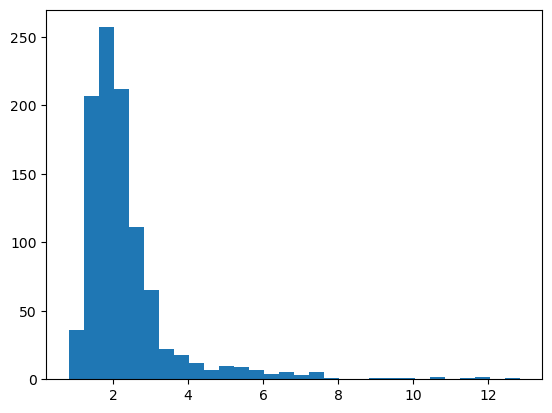

In [6]:
#here's where I'll find the actual epsilon and do the BDSCAN

#findind k-NN so as to determine a good distance to use as epsilon
def k_NN_func(dist_table, k):
    k_NN_dist = []
    eucl_dist = []
    for i in range(len(dist_table)):
        eucl_dist = dist_table[i]
        eucl_dist.sort()
        k_NN_dist.append(eucl_dist[k])

    return k_NN_dist

distances = k_NN_func(dtable, 10)

plt.hist(distances,bins=30)



Epsilon appears to be around 10.5 here and that's the number that's to be used for the DBSCAN with minPoints being 10. 

In [ ]:
#do the DBSCAN 
from sklearn.cluster import DBSCAN 

dbscan = DBSCAN(eps=10.5, min_samples=10).fit(df_scan)

### Predictive model

only the second attempt part SEEMS to work but still with the scaler i feel it's a little confusing whether there's any actual result or not

In [ ]:
#second attempt with ANN - wrong
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import load_model
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#create data
data = df_final 
X = data[['building_id', 'ta', 'rh', 'vel', 'met']]
y = data[['thermal_sensation']]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

#separate into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

#create model
model = Sequential()
model.add(Dense(40, kernel_initializer= 'uniform', activation= 'relu', input_dim = 5))
model.add(Dense(40, kernel_initializer= 'uniform', activation= 'relu'))
model.add(Dense(40, kernel_initializer= 'uniform', activation= 'relu'))
model.add(Dense(1, kernel_initializer= 'uniform', activation= 'sigmoid'))

model.summary()

model.compile(optimizer= 'adam', loss = 'mse', metrics = ['mse', 'mae'])

#fit model
model.fit(X_train, y_train, batch_size= 128, epochs= 100)

#make predictions
y_pred = model.predict(X_test)

In [ ]:
#errors
import math
rmse = mean_squared_error(y_pred, y_test)
print(math.sqrt(rmse))

mae = mean_absolute_error(y_pred, y_test)
print(mae)

test_results = pd.DataFrame(data = {'Predicted':y_pred.ravel(), 'Actual':y_test.ravel()})
comparison =  pd.DataFrame(data = {'Original':data['thermal_sensation'], 'New':y.ravel()})
path = str(pathlib.Path().resolve()) + '\\results.csv' #stores file for future use
path2 = str(pathlib.Path().resolve()) + '\\comparison.csv' #stores file for future use
test_results.to_csv(path, sep = ' ')
comparison.to_csv(path2, sep = ' ')